## Imports

In [1]:
import pandas as pd
import datetime as dt
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re # Python's package for RegEx (Regular Expressions)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
pd.set_option('display.max_columns', None) # Displays all columns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

[nltk_data] Downloading package wordnet to /Users/ch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ch/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
pwd!

'/Users/ch/Desktop/GA/Projects/project_3'

In [3]:
selectedfeatures = pd.read_csv('Datasets/selectedfeatures.csv',lineterminator='\n')

In [4]:
selectedfeatures['subreddit'].value_counts()

0    11374
1    11062
Name: subreddit, dtype: int64

In [5]:
selectedfeatures['selftextwordcount'] = selectedfeatures['selftext'].str.split().str.len()

In [6]:
selectedfeatures.isnull().sum()

selftext                   0
subreddit                  0
cleantext                523
cleantexttokenized       523
cleantexttokenizedlem    523
tokenized                 12
lemtokenized              12
selftextwordcount          0
dtype: int64

In [7]:
selectedfeatures.loc[selectedfeatures['cleantext'].isna(),['selftext','cleantext']]

,selftext,cleantext
81,I really though I had more time.,NaN
112,https://youtu.be/mUkh-aLftXw,NaN
113,https://youtu.be/mUkh-aLftXw,NaN
170,https://imgur.com/a/XO2p7Cp,NaN
298,I would like some.,NaN
...,...,...
22126,http://metro.co.uk/2015/06/08/e3-2015-preview-...,NaN
22284,http://www.gamespot.com/articles/sony-treating...,NaN
22385,https://twitter.com/NoMansSky/status/593549483...,NaN
22395,http://imgur.com/5GPVkrg\n\nhttp://imgur.com/K...,NaN


In [8]:
selectedfeatures.dropna(inplace=True)

In [9]:
selectedfeatures.shape

(21913, 8)

# Baseline Accuracy for Future Models = 0.507 Plurality Class

In [10]:
print('Baseline Accuracy is Predicting the Plurality Class')
selectedfeatures['subreddit'].value_counts(normalize=True)

Baseline Accuracy is Predicting the Plurality Class


0    0.51563
1    0.48437
Name: subreddit, dtype: float64

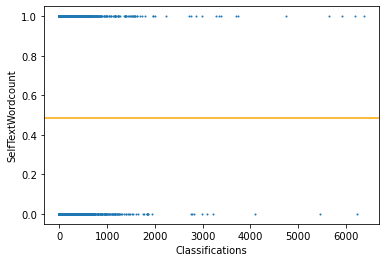

In [11]:
plt.scatter(selectedfeatures['selftextwordcount'],selectedfeatures['subreddit'],s = 1)
plt.axhline(selectedfeatures['subreddit'].mean(), color = 'orange')
plt.xlabel('Classifications')
plt.ylabel('SelfTextWordcount');

In [12]:
selectedfeatures.head(2)

,selftext,subreddit,cleantext,cleantexttokenized,cleantexttokenizedlem,tokenized,lemtokenized,selftextwordcount
0,"Idk but the whole ""replace humans with synths ...",1,idk replace humans synths mysterious institute...,idk replace humans synths mysterious institute...,idk replace human synths mysterious institute ...,idk but the whole replace humans with synths f...,idk but the whole replace human with synths fr...,119
1,"I need it for university, didn't know where e...",1,need university didnt post,need university didnt post,need university didnt post,i need it for university didn t know where els...,i need it for university didn t know where els...,12


## Defining Results of GridSearch

## Model 1 - Pipe / Grid / CountVectorizer / MultinomialNB / Selftext

In [17]:
selectedfeatures.head(0)

,selftext,subreddit,cleantext,cleantexttokenized,cleantexttokenizedlem,tokenized,lemtokenized,selftextwordcount


In [27]:
X = selectedfeatures['selftext'] # Tried selftext / # 
y = selectedfeatures['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)
pipe= Pipeline([('cvec', CountVectorizer()),('nb', MultinomialNB())])
pipe_params = {
    'cvec__max_features': [8500],
    'cvec__min_df': [3],
    'cvec__max_df': [.78,.80],
    'cvec__ngram_range': [(1,1),(1,2)], # one word / oneword,two words
    'cvec__stop_words': [None]}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=5,
                 verbose=1,
                 n_jobs=-1) # 5-fold cross-validation.

# Fit GridSearch to training data.
gs.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.78, 0.8],
                         'cvec__max_features': [8500], 'cvec__min_df': [3, 3.1],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None]},
             verbose=1)

Best Estimator: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.8, max_features=8500, min_df=3)),
                ('nb', MultinomialNB())])
Grid Search Best Score: 0.9373855878512911
Grid Search CV Train Score: 0.9458439819885603
Grid Search CV Test Score: 0.9324694287278701
Grid Search CV Sensititivity: 0.9199748743718594
Grid Search CV Precision: 0.9491998097230823
Grid Search CV F1: 0.9343429059994085
Grid Search CV Roc Auc: 0.9869200319106932
Specificity: 0.943716814159292
TPR: 0.9199748743718594
FPR: 0.05628318584070797
Best Parameters: {'cvec__max_df': 0.8, 'cvec__max_features': 8500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}


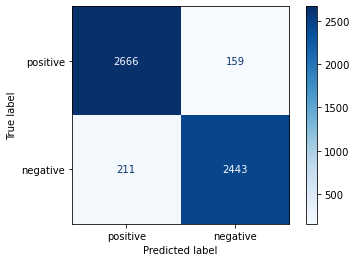

In [28]:
print('Best Estimator:', gs.best_estimator_)
print('Grid Search Best Score:',gs.best_score_) 
print('Grid Search CV Train Score:',gs.score(X_train,y_train)) 
print('Grid Search CV Test Score:',gs.score(X_test,y_test)) # Minimize false positives
print('Grid Search CV Sensititivity:', cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='roc_auc').mean())
preds = gs.predict(X_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gs.best_params_)
plot_confusion_matrix(gs,X_test,y_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

In [29]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs.predict_proba(X_test)[:,1]}) #prob in class 1

In [30]:
pred_df.head()

,true_values,pred_probs
10380,1,8.976871e-01
10339,1,9.987021e-01
12914,0,3.425184e-09
14709,0,4.843617e-01
18508,0,1.500905e-04


/Users/ch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


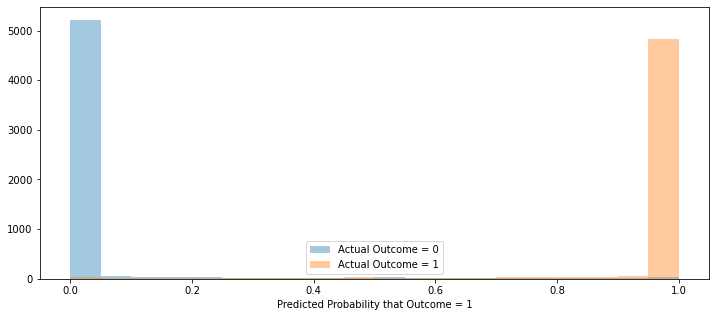

In [31]:
plt.figure(figsize = (12, 5))

for group in pred_df.groupby('true_values'): # plot distributions of predicted probabilities by actual values
    sns.distplot(group[1], 
                 kde = False, 
                 bins = 20, 
                 label = f'Actual Outcome = {group[0]}')
plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

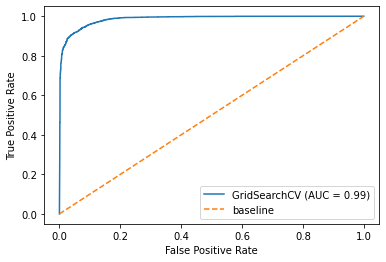

In [32]:
plot_roc_curve(gs,X_test,y_test,) # ROC curve
#       X-axis Y-axis 
plt.plot([0,1],[0,1], label='baseline',linestyle='--') # add worst case scenario line
plt.legend(); # add a legend

In [35]:
roc_auc_score(y_test,gs.predict_proba(X_test)[:,1])

0.9856991950703898

## Comparison to Baseline Accuracy: Interpretation of Model 1
Baseline Accuracy for Plurality Class is 0.51563. Model 1 Naive Bayes significantly outperformed the Baseline Accuracy of 0.51563. 
**Model 1 Naive Bayes scores at the top of the list with the highest performance.**
For this model I used the CountVectorizer() in order to compare to TfidfVectorizer(). I used selftext to compare original data as X versus cleaned and lematized data as X.

Model 1 is relatively **low variance** since the train accuracy and test accuracy scores are pretty great. The model is picking up on meaningful data and assembling proper relationships. Accuracy of 0.9364 on cross validation test is satisfactory. Model 1 has almost **no bias** since it predicts consistently between test and train scores and achieves pretty great scores. This shows the model is correctly fit to the training data. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is overfit and is high-bias. Since there is only some slight difference
between cross validation scores between train and test, I am relatively confident the model doesn't show signs of having bias or being overfit.

All the other classification scores are excellent.

## Model 2 - Pipe / Grid / CountVectorizer / MultinomialNB / RegExTokenized

In [36]:
selectedfeatures.head(0)

,selftext,subreddit,cleantext,cleantexttokenized,cleantexttokenizedlem,tokenized,lemtokenized,selftextwordcount


In [40]:
X = selectedfeatures['tokenized']
y = selectedfeatures['subreddit'] # 0 or 1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)

pipe= Pipeline([('cvec', CountVectorizer()),('nb', MultinomialNB())])

pipe_params = {
    'cvec__max_features': [5000,5300],
    'cvec__min_df': [3,3.1,3.2],
    'cvec__max_df': [.75,.80],
    'cvec__ngram_range': [(1,1)], # one word / oneword,two words
    'cvec__stop_words': ['english']}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  verbose=1,
                  n_jobs=-1)

# Fit GridSearch to training data.
gs.fit(X_train,y_train)
gs.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   33.2s finished


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=3,
                                 stop_words='english')),
                ('nb', MultinomialNB())])

Best Estimator: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=3,
                                 stop_words='english')),
                ('nb', MultinomialNB())])
Grid Search Best Score: 0.9355603077543527
Grid Search CV Train Score: 0.9418279177315322
Grid Search CV Test Score: 0.9304617630954554
Grid Search CV Sensititivty: 0.924748743718593
Grid Search CV Precision: 0.9412067977866844
Grid Search CV F1: 0.9328916304073557
Grid Search CV Roc Auc: 0.9874967857374308
Specificity: 0.9408849557522124
TPR: 0.924748743718593
FPR: 0.05911504424778761
Best Parameters: {'cvec__max_df': 0.75, 'cvec__max_features': 5000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}


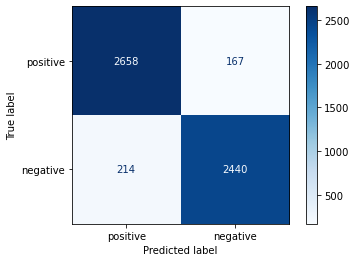

In [41]:
print('Best Estimator:', gs.best_estimator_)
print('Grid Search Best Score:',gs.best_score_)
print('Grid Search CV Train Score:',gs.score(X_train,y_train))
print('Grid Search CV Test Score:',gs.score(X_test,y_test))
print('Grid Search CV Sensititivty:', cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='roc_auc').mean())
preds = gs.predict(X_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gs.best_estimator_,X_train, y_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gs.best_params_)
plot_confusion_matrix(gs,X_test,y_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

## Comparison to Baseline Accuracy: Interpretation of Model 2
Baseline Accuracy for Plurality Class is 0.51563.

Model 2 Naive Bayes significantly outperformed the Baseline Accuracy of 0.51563.
Model 2 Naive Bayes scores very close with model 1 Naive Bayes.
For this model I used the CountVectorizer() in order to compare to TfidfVectorizer().

I used lematized data as X versus the original selftext as X. Model 2 is relatively **low variance** since the train accuracy and test accuracy scores are pretty great in the 0.93 range respestively. The model is picking up mostly on meaningful data and assembling proper relationships. Accuracy of 0.9301 on cross validation test is satisfactory. Model 2 has almost **no bias** since it predicts consistently between test and train scores. This shows the model is correctly fit to the training data. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is overfit and is high-bias. 

Since there is only some slight between cross validation scores between train and test, I am relatively confident the model doesn't show signs of having bias or being overfit.

All the other classification scores are excellent.

## Model 3 - Pipe / Grid / TFIDf / MultinomialNB / Lemtokenized

In [48]:
selectedfeatures.head(0)

,selftext,subreddit,cleantext,cleantexttokenized,cleantexttokenizedlem,tokenized,lemtokenized,selftextwordcount


In [54]:
Xt = selectedfeatures['lemtokenized']
yt = selectedfeatures['subreddit']
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt,yt,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)
pipe= Pipeline([('tvec', TfidfVectorizer()),('nb', MultinomialNB())])
pipe_params = {
    'tvec__max_features': [4000],
    'tvec__min_df': [15],
    'tvec__max_df': [.8,.95],
    'tvec__ngram_range': [(1,1)], # one word / oneword,two words
    'tvec__stop_words': ['english']}
gstvec = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                     verbose=1,
                     n_jobs=-1) 
gstvec.fit(Xt_train,yt_train) # Fit GridSearch to training data.

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.8, 0.95],
                         'tvec__max_features': [4000], 'tvec__min_df': [15],
                         'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': ['english']},
             verbose=1)

Best Estimator: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=4000, min_df=15,
                                 stop_words='english')),
                ('nb', MultinomialNB())])
Grid Search Best Score: 0.9314225000791587
Grid Search CV Train Score: 0.9445052939028843
Grid Search CV Test Score: 0.9268114619456105
Grid Search CV Sensititivty: 0.9223618090452261
Grid Search CV Precision: 0.9351845494803014
Grid Search CV F1: 0.9287152812842047
Grid Search CV Roc Auc: 0.9849619295538755
Specificity: 0.9302654867256637
TPR: 0.9223618090452261
FPR: 0.06973451327433629
Best Parameters: {'tvec__max_df': 0.8, 'tvec__max_features': 4000, 'tvec__min_df': 15, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


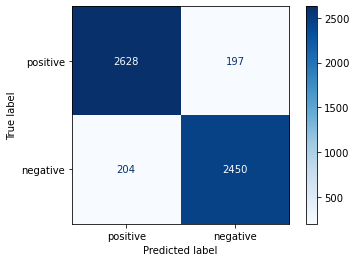

In [55]:
print('Best Estimator:', gstvec.best_estimator_)
print('Grid Search Best Score:',gstvec.best_score_)
print('Grid Search CV Train Score:',gstvec.score(Xt_train,yt_train))
print('Grid Search CV Test Score:',gstvec.score(Xt_test,yt_test))
print('Grid Search CV Sensititivty:', cross_val_score(gstvec.best_estimator_,Xt_train, yt_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gstvec.best_estimator_,Xt_train, yt_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gstvec.best_estimator_,Xt_train, yt_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gstvec.best_estimator_,Xt_train, yt_train,cv = 5,scoring='roc_auc').mean())
preds = gstvec.predict(Xt_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(yt_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gstvec.best_estimator_,Xt_train, yt_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gstvec.best_params_)
plot_confusion_matrix(gstvec,Xt_test,yt_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

## Comparison to Baseline Accuracy: Interpretation of Model 3

Baseline Accuracy for Plurality Class is 0.51563.

Model 3 Naive Bayes significantly outperformed the Baseline Accuracy of 0.51563.
Model 3 Naive Bayes scores very close with model 1 Naive Bayes. For this model I used the TfidfVectorizer in order to compare to count vectorizer.

I used selftext to compare original data as X versus cleaned and lematized data as X. Model 3 is relatively **low variance** since the train accuracy and test accuracy scores are pretty great. The model is picking up on meaningful data and assembling proper relationships. Accuracy of 0.91 on cross validation test is satisfactory. Model 3 has very **low bias** since it predicts consistently between test and train scores. This shows the model is correctly fit to the training data. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is overfit and is high-bias. Since there is only some slight between cross validation scores between train and test, I am relatively confident the model doesn't show signs of having significant bias or being overfit.

I tuned the hyper parameters through multiple executions of the classifier, and removed hyper parameters that didn't suit the model.

All the other classification scores are excellent.

## Model 4 - Pipe / Grid / TFIDf / MultinomialNB / Tokenized 

In [61]:
Xtl = selectedfeatures['tokenized']
ytl = selectedfeatures['subreddit']
Xtl_train, Xtl_test, ytl_train, ytl_test = train_test_split(Xtl,ytl,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)
pipe= Pipeline([('tvec', TfidfVectorizer()),('nb', MultinomialNB())])
pipe_params = {
    'tvec__max_features': [5000],
    'tvec__min_df': [3,7,11],
    'tvec__max_df': [.80],
    'tvec__ngram_range': [(1,1)], # one word / oneword,two words
    'tvec__stop_words': ['english']}
gstvecl = GridSearchCV(pipe, # what object are we optimizing?
                       pipe_params, # what parameters values are we searching?
                       cv=5, # 5-fold cross-validation.
                       verbose=1,
                       n_jobs=-1)

gstvecl.fit(Xtl_train,ytl_train) # Fit GridSearch to training data.

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    8.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.8], 'tvec__max_features': [5000],
                         'tvec__min_df': [3, 7, 11],
                         'tvec__ngram_range': [(1, 1)],
                         'tvec__stop_words': ['english']},
             verbose=1)

Best Estimator: Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, max_features=5000, min_df=7,
                                 stop_words='english')),
                ('nb', MultinomialNB())])
Grid Search Best Score: 0.9323350753193059
Grid Search CV Train Score: 0.946939272240477
Grid Search CV Test Score: 0.9284540974630408
Grid Search CV Sensititivty: 0.9241206030150753
Grid Search CV Precision: 0.9354179943825545
Grid Search CV F1: 0.9297246060907988
Grid Search CV Roc Auc: 0.985494870034402
Specificity: 0.9323893805309734
TPR: 0.9241206030150753
FPR: 0.06761061946902655
Best Parameters: {'tvec__max_df': 0.8, 'tvec__max_features': 5000, 'tvec__min_df': 7, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


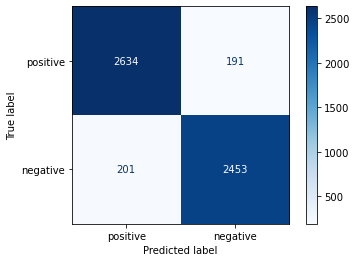

In [62]:
print('Best Estimator:', gstvecl.best_estimator_)
print('Grid Search Best Score:',gstvecl.best_score_)
print('Grid Search CV Train Score:',gstvecl.score(Xtl_train,ytl_train))
print('Grid Search CV Test Score:',gstvecl.score(Xtl_test,ytl_test))
print('Grid Search CV Sensititivty:', cross_val_score(gstvecl.best_estimator_,Xtl_train, ytl_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gstvecl.best_estimator_,Xtl_train, ytl_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gstvecl.best_estimator_,Xtl_train, ytl_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gstvecl.best_estimator_,Xtl_train, ytl_train,cv = 5,scoring='roc_auc').mean())
preds = gstvecl.predict(Xtl_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(ytl_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gstvecl.best_estimator_,Xtl_train, ytl_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gstvecl.best_params_)
plot_confusion_matrix(gstvecl,Xtl_test,ytl_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

## Comparison to Baseline Accuracy: Interpretation of Model 4
Baseline Accuracy for Plurality Class is 0.51563.

Model 4 Naive Bayes significantly outperformed the Baseline Accuracy of 0.51563.
Model 4 Naive Bayes scores very close with model 1 Naive Bayes.
For this model I used the TfidfVectorizer in order to compare to count vectorizer.

Model 4 is relatively **low variance** since the train accuracy and test accuracy scores are pretty great. The model is picking up on meaningful data assembling proper relationships. Accuracy of 0.91 on cross validation test is satisfactory. Model 4 has **low bias** since it predicts consistently between test and train scores. This shows the model is correctly fit to the training data. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is overfit and is high-bias. Since there is only some difference between cross validation scores between train and test, I am relatively confident the model doesn't show signs of having bias or being overfit.

I tuned the hyper parameters through multiple executions of the classifier, and removed hyper parameters that didn't suit the model.

All the other classification scores are excellent.

# Model 5 - Pipe / Grid / TF-IDF / LogisticRegression 

In [63]:
Xlg = selectedfeatures['selftext']
ylg = selectedfeatures['subreddit']
Xlg_train, Xlg_test, ylg_train, ylg_test = train_test_split(Xlg,ylg,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)
pipe= Pipeline([('cvec', CountVectorizer()),
                ('ss', StandardScaler(with_mean=False)),
                ('lg', LogisticRegression(solver='liblinear',penalty='l2'))])
pipe_params = {
    'cvec__max_features': [3000],
    'cvec__min_df': [20,23],
    'cvec__max_df': [.7,.75],
    'cvec__ngram_range': [(1,1),(1,2)], # one word / oneword,two words
    'lg__C': [.001,.01],
    'cvec__stop_words': [None, 'english']}

gslg = GridSearchCV(pipe, # what object are we optimizing?
                    pipe_params, # what parameters values are we searching?
                    cv=5,
                    verbose=1,
                    n_jobs=-1) # 5-fold cross-validation.

# Fit GridSearch to training data.
gslg.fit(Xlg_train,ylg_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('lg',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.7, 0.75],
                         'cvec__max_features': [3000], 'cvec__min_df': [20, 23],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lg__C': [0.001, 0.01]},
             verbose=1)

Best Estimator: Pipeline(steps=[('cvec',
                 TfidfVectorizer(max_df=0.75, max_features=2800, min_df=20)),
                ('ss', StandardScaler(with_mean=False)),
                ('lg', LogisticRegression(C=0.01, solver='liblinear'))])
Grid Search Best Score: 0.8988679837816249
Grid Search CV Train Score: 0.9720700985761227
Grid Search CV Test Score: 0.9056397152765103
Grid Search CV Sensititivty: 0.8954773869346735
Grid Search CV Precision: 0.895704890465662
Grid Search CV F1: 0.8955884963187488
Grid Search CV Roc Auc: 0.96706321385532
Specificity: 0.9026548672566371
TPR: 0.8954773869346735
FPR: 0.09734513274336283
Best Parameters: {'cvec__max_df': 0.75, 'cvec__max_features': 2800, 'cvec__min_df': 20, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lg__C': 0.01}


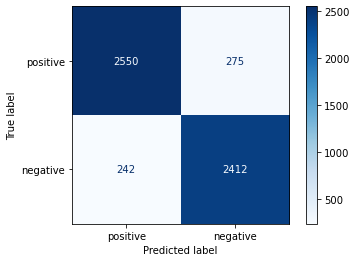

In [67]:
print('Best Estimator:', gslg.best_estimator_)
print('Grid Search Best Score:',gslg.best_score_)
print('Grid Search CV Train Score:',gslg.score(Xlg_train,ylg_train))
print('Grid Search CV Test Score:',gslg.score(Xlg_test,ylg_test))
print('Grid Search CV Sensititivty:', cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='roc_auc').mean())
preds = gslg.predict(Xlg_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(ylg_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gslg.best_params_)
plot_confusion_matrix(gslg,Xlg_test,ylg_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

## Comparison to Baseline Accuracy: Interpretation of Model 5
Baseline Accuracy for Plurality Class is 0.51563.

Model 5 Logistic Regression significantly outperformed the Baseline Accuracy of 0.51563.
But also came very close to Model 1 Naive Bayes scores, just like the other logreg model.
For this model I used CountVectorizer() in order to compare to how TfidfVectorizer performs on logistic regression models.

Model 5 is relatively **low variance** since the train accuracy and test accuracy scores are pretty great. The model is picking up on meaningful data assembling proper relationships. Accuracy of 0.91 on cross validation test is satisfactory. Model 5 has **some bias** since it predicts consistently between test and train scores, but there is still a 0.05 difference between train and test cross validation scores. This shows the model slightly overfit to the training data. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is overfit and is high-bias. Since there is only some difference between cross validation scores between train and test, I am relatively confident the model doesn't show signs of being high bias.

I tuned the hyper parameters through multiple executions of the classifier, and removed hyper parameters that didn't suit the model.

All the other classification scores were excellent.

# Model 6 - Pipe / Grid / TFIDf / LogisticRegression / Lemtokenized

In [65]:
selectedfeatures.head(0)

,selftext,subreddit,cleantext,cleantexttokenized,cleantexttokenizedlem,tokenized,lemtokenized,selftextwordcount


In [66]:
Xlg = selectedfeatures['cleantext']
ylg = selectedfeatures['subreddit']
Xlg_train, Xlg_test, ylg_train, ylg_test = train_test_split(Xlg,ylg,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)
pipe= Pipeline([('cvec', TfidfVectorizer()),
                ('ss', StandardScaler(with_mean=False)),
                ('lg', LogisticRegression(solver='liblinear',penalty='l2'))])
pipe_params = {
    'cvec__max_features': [2800,3000],
    'cvec__min_df': [2,4,10,15,20],
    'cvec__max_df': [.75,.85,.95],
    'cvec__ngram_range': [(1,1),(1,2)], # one word / oneword,two words
    'lg__C': [.01],
    'cvec__stop_words': [None, 'english']}

gslg = GridSearchCV(pipe, # what object are we optimizing?
                    pipe_params, # what parameters values are we searching?
                    cv=5,
                    verbose=1,
                    n_jobs=-1) # 5-fold cross-validation.

# Fit GridSearch to training data.
gslg.fit(Xlg_train,ylg_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  8.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', TfidfVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('lg',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.75, 0.85, 0.95],
                         'cvec__max_features': [2800, 3000],
                         'cvec__min_df': [2, 4, 10, 15, 20],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lg__C': [0.01]},
             verbose=1)

Best Estimator: Pipeline(steps=[('cvec',
                 TfidfVectorizer(max_df=0.75, max_features=2800, min_df=20)),
                ('ss', StandardScaler(with_mean=False)),
                ('lg', LogisticRegression(C=0.01, solver='liblinear'))])
Grid Search Best Score: 0.8988679837816249
Grid Search CV Train Score: 0.9720700985761227
Grid Search CV Test Score: 0.9056397152765103
Grid Search CV Sensititivty: 0.8954773869346735
Grid Search CV Precision: 0.895704890465662
Grid Search CV F1: 0.8955884963187488
Grid Search CV Roc Auc: 0.96706321385532
Specificity: 0.9026548672566371
TPR: 0.8954773869346735
FPR: 0.09734513274336283
Best Parameters: {'cvec__max_df': 0.75, 'cvec__max_features': 2800, 'cvec__min_df': 20, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lg__C': 0.01}


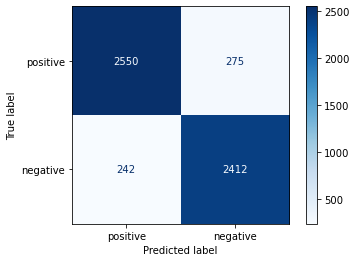

In [68]:
print('Best Estimator:', gslg.best_estimator_)
print('Grid Search Best Score:',gslg.best_score_)
print('Grid Search CV Train Score:',gslg.score(Xlg_train,ylg_train))
print('Grid Search CV Test Score:',gslg.score(Xlg_test,ylg_test))
print('Grid Search CV Sensititivty:', cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='roc_auc').mean())
preds = gslg.predict(Xlg_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(ylg_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gslg.best_estimator_,Xlg_train, ylg_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gslg.best_params_)
plot_confusion_matrix(gslg,Xlg_test,ylg_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

## Comparison to Baseline Accuracy: Interpretation of Model 6
Baseline Accuracy for Plurality Class is 0.51563.

Model 6 Logistic Regression significantly outperformed the Baseline Accuracy of 0.51563.
But also came very close to Model 1 Naive Bayes scores.

On this model I used TfidfVectorizer() to test against CountVectorizer effects on Logistic Regression models. Model 6 has slight **bias** since the train accuracy and test accuracy scores are in the 90th percentile. The model is mostly picking up on meaningful data assembling proper relationships. 

Accuracy of 0.91 on cross validation test is satisfactory. Model 6 has **some variance** since it predicts somewhat consistently between test and train scores, but there is still a 0.05 difference between train and test cross validation scores. This shows the model is slightly overfit to the training data. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is high variance. With some difference between cross validation scores between train and test, I am  confident the model doesn't show signs of being high variance.

I tuned the hyper parameters through multiple executions of the classifier, and removed hyper parameters that didn't suit the model. All the other classification scores are satisfactory.

# Model 7 - Pipe / Grid / CountVectorizer / DecisionTree / Selftext

In [71]:
Xdt = selectedfeatures['selftext']
ydt = selectedfeatures['subreddit']
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(Xdt,ydt,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)
pipe= Pipeline([('cvec', CountVectorizer()),('dt', DecisionTreeClassifier())])
pipe_params = {
    'cvec__max_features': [3000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [.75],
    'cvec__ngram_range': [(1,1)], # one word / oneword,two words
    'cvec__stop_words': ['english'],
    'dt__max_depth':[7],
    'dt__min_samples_split':[7,12],
    'dt__min_samples_leaf':[3],
    'dt__ccp_alpha':[0.01, 0.1, 1]}

gsdt = GridSearchCV(pipe, # what object are we optimizing?
                    pipe_params, # what parameters values are we searching?
                    cv=5, # 5-fold cross-validation.
                    verbose=1, # communicates whats happening/ how many fits
                    n_jobs=-1) # how many cores will go to work
gsdt.fit(Xdt_train,ydt_train) # Fit GridSearch to training data.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   46.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.75], 'cvec__max_features': [3000],
                         'cvec__min_df': [2, 3], 'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': ['english'],
                         'dt__ccp_alpha': [0.01, 0.1, 1], 'dt__max_depth': [7],
                         'dt__min_samples_leaf': [3],
                         'dt__min_samples_split': [7, 12]},
             verbose=1)

Best Estimator: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.75, max_features=3000, min_df=2,
                                 stop_words='english')),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.01, max_depth=7,
                                        min_samples_leaf=3,
                                        min_samples_split=7))])
Grid Search Best Score: 0.711817130913366
Grid Search CV Train Score: 0.711816964829013
Grid Search CV Test Score: 0.7130863296221939
Grid Search CV Sensititivty: 0.9953517587939699
Grid Search CV Precision: 0.6277411715748036
Grid Search CV F1: 0.7699081976302942
Grid Search CV Roc Auc: 0.8234508041525832
Specificity: 0.8913274336283186
TPR: 0.9953517587939699
FPR: 0.10867256637168142
Best Parameters: {'cvec__max_df': 0.75, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'dt__ccp_alpha': 0.01, 'dt__max_depth': 7, 'dt__min_samples_leaf': 3, 'dt__

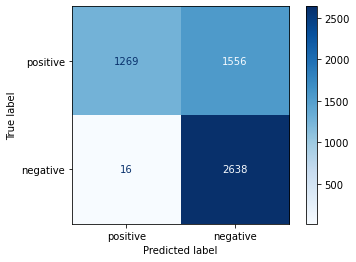

In [72]:
print('Best Estimator:', gsdt.best_estimator_)
print('Grid Search Best Score:',gsdt.best_score_)
print('Grid Search CV Train Score:',gsdt.score(Xdt_train,ydt_train))
print('Grid Search CV Test Score:',gsdt.score(Xdt_test,ydt_test))
print('Grid Search CV Sensititivty:', cross_val_score(gsdt.best_estimator_,Xdt_train, ydt_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gsdt.best_estimator_,Xdt_train, ydt_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gsdt.best_estimator_,Xdt_train, ydt_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gsdt.best_estimator_,Xdt_train, ydt_train,cv = 5,scoring='roc_auc').mean())
preds = gslg.predict(Xdt_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(ydt_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gsdt.best_estimator_,Xdt_train, ydt_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gsdt.best_params_)
plot_confusion_matrix(gsdt,Xdt_test,ydt_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

## Comparison to Baseline Accuracy: Interpretation of Model 7
Baseline Accuracy for Plurality Class is 0.51563.

Model 7 Decision Tree still outperformed the Baseline Accuracy of 0.51563.
But didn't come close to Model 1 Naive Bayes scores either.

Model 7 is somewhat **high** bias / overfit since the train accuracy and test accuracy scores are just alright. The model is picking up on static and meaningless data. Accuracy of 0.71 is nothing to be overwhelmed by. Model 7 has low **variance** since it predicts consistently between test and train scores. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is high variance. Since there is almost no difference between cross validation scores between train and test, I am confident the model is low variance.

The classifier consistency predicts mediocre results. The other classification scores are questionable. With cross validation scores where they are, I wasn't expecting the difference between the cv scores and the Specificity or Precision, at 0.4454 and 0.6327 respectively. I tuned the hyper parameters through multiple executions of the classifier, and removed hyper parameters that didn't suit the model.

# Model 8 - Pipe / Grid / CountVectorizer/ DecisionTree / Lemtokenized

In [73]:
Xdt2 = selectedfeatures['lemtokenized']
ydt2 = selectedfeatures['subreddit']
Xdt2_train, Xdt2_test, ydt2_train, ydt2_test = train_test_split(Xdt2,ydt2,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)
pipe= Pipeline([('cvec', CountVectorizer()),('dt', DecisionTreeClassifier())])

pipe_params = {
    'cvec__max_features': [3000],
    'cvec__min_df': [1,2],
    'cvec__max_df': [.70],
    'cvec__ngram_range': [(1,1)], # one word / oneword,two words
    'cvec__stop_words': ['english'],
    'dt__max_depth':[3,7],
    'dt__min_samples_split':[5, 10],
    'dt__min_samples_leaf':[2,6],
    'dt__ccp_alpha':[0.001,0.01]}

gsdt2 = GridSearchCV(pipe, # what object are we optimizing?
                    pipe_params, # what parameters values are we searching?
                    cv=5, # 5-fold cross-validation.
                    verbose=1, # communicates whats happening/ how many fits
                    n_jobs=-1) # how many cores will go to work

gsdt2.fit(Xdt2_train,ydt2_train) # Fit GridSearch to training data.

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.7], 'cvec__max_features': [3000],
                         'cvec__min_df': [1, 2], 'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': ['english'],
                         'dt__ccp_alpha': [0.001, 0.01],
                         'dt__max_depth': [3, 7],
                         'dt__min_samples_leaf': [2, 6],
                         'dt__min_samples_split': [5, 10]},
             verbose=1)

Best Estimator: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.7, max_features=3000,
                                 stop_words='english')),
                ('dt',
                 DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7,
                                        min_samples_leaf=2,
                                        min_samples_split=5))])
Grid Search Best Score: 0.74936133250354
Grid Search CV Train Score: 0.7494219301448217
Grid Search CV Test Score: 0.7453914947983209
Grid Search CV Sensititivty: 0.9873115577889449
Grid Search CV Precision: 0.6617311787913598
Grid Search CV F1: 0.792367586477946
Grid Search CV Roc Auc: 0.8649733838521805
Specificity: 0.5207079646017699
TPR: 0.9873115577889449
FPR: 0.47929203539823007
Best Parameters: {'cvec__max_df': 0.7, 'cvec__max_features': 3000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'dt__ccp_alpha': 0.001, 'dt__max_depth': 7, 'dt__min_samples_leaf': 2, 'dt__min_samples

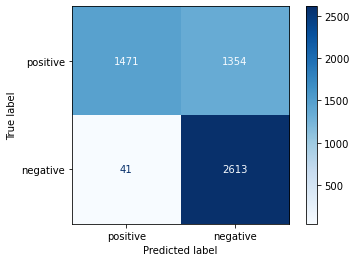

In [74]:
print('Best Estimator:', gsdt2.best_estimator_)
print('Grid Search Best Score:',gsdt2.best_score_)
print('Grid Search CV Train Score:',gsdt2.score(Xdt2_train,ydt2_train))
print('Grid Search CV Test Score:',gsdt2.score(Xdt2_test,ydt2_test))
print('Grid Search CV Sensititivty:', cross_val_score(gsdt2.best_estimator_,Xdt2_train, ydt2_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gsdt2.best_estimator_,Xdt2_train, ydt2_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gsdt2.best_estimator_,Xdt2_train, ydt2_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gsdt2.best_estimator_,Xdt2_train, ydt2_train,cv = 5,scoring='roc_auc').mean())
preds = gsdt2.predict(Xdt2_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(ydt2_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gsdt2.best_estimator_,Xdt2_train, ydt2_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gsdt2.best_params_)
plot_confusion_matrix(gsdt2,Xdt2_test,ydt2_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

## Comparison to Baseline Accuracy: Interpretation of Model 8
Baseline Accuracy for Plurality Class is 0.51563.

Model 8 Decision Tree still outperformed the Baseline Accuracy of 0.51563.
But didn't come close to Model 1 Naive Bayes scores either. Model 8 is **high** bias since the train accuracy and test accuracy scores are just alright. The model is picking up on static and meaningless data.

Model 8 is **low variance** since it predicts consistently between test and train scores. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is high variance. I tuned the hyper parameters through multiple executions of the classifier, and removed hyper parameters that didn't suit the model.

# Model 9 - Pipe / Grid / CountVectorizer / Bagging Classifier Ensemble / Tokenized

In [75]:
selectedfeatures.head(0)

,selftext,subreddit,cleantext,cleantexttokenized,cleantexttokenizedlem,tokenized,lemtokenized,selftextwordcount


In [76]:
Xbc = selectedfeatures['cleantexttokenizedlem']
ybc = selectedfeatures['subreddit']
Xbc_train, Xbc_test, ybc_train, ybc_test = train_test_split(Xbc,ybc,test_size=0.25,
                                                    stratify=y, # Equal Proportions
                                                    random_state=42)

pipe= Pipeline([('cvec', CountVectorizer()),('bc', BaggingClassifier())])

pipe_params = {
    'cvec__max_features': [2500, 3000],
    'cvec__min_df': [9,15],
    'cvec__max_df': [.90, .95],
    'cvec__ngram_range': [(1,1)], # one word / oneword,two words
    'cvec__stop_words': [None, 'english'],
    'bc__n_estimators':[100,150],
    'bc__max_samples':[25,35]}
    

gsbc = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=5, # 5-fold cross-validation.
                  verbose=1,
                  n_jobs=-1) 

# Fit GridSearch to training data.
gsbc.fit(Xbc_train,ybc_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  5.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bc', BaggingClassifier())]),
             n_jobs=-1,
             param_grid={'bc__max_samples': [25, 35],
                         'bc__n_estimators': [100, 150],
                         'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2500, 3000],
                         'cvec__min_df': [9, 15], 'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

Best Estimator: Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=2500, min_df=15,
                                 stop_words='english')),
                ('bc', BaggingClassifier(max_samples=35, n_estimators=100))])
Grid Search Best Score: 0.7809429277548305
Grid Search CV Train Score: 0.7409030059632469
Grid Search CV Test Score: 0.7311553203139259
Grid Search CV Sensititivty: 0.6330402010050251
Grid Search CV Precision: 0.9462545057431928
Grid Search CV F1: 0.691687920171662
Grid Search CV Roc Auc: 0.8952143432664501
Specificity: 0.9798230088495575
TPR: 0.6057788944723619
FPR: 0.020176991150442476
Best Parameters: {'bc__max_samples': 35, 'bc__n_estimators': 100, 'cvec__max_df': 0.9, 'cvec__max_features': 2500, 'cvec__min_df': 15, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}


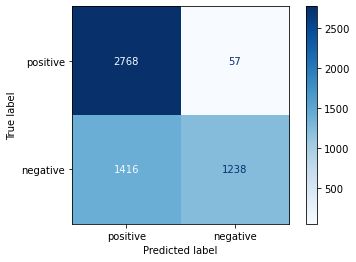

In [77]:
print('Best Estimator:', gsbc.best_estimator_)
print('Grid Search Best Score:',gsbc.best_score_)
print('Grid Search CV Train Score:',gsbc.score(Xbc_train,ybc_train))
print('Grid Search CV Test Score:',gsbc.score(Xbc_test,ybc_test))
print('Grid Search CV Sensititivty:', cross_val_score(gsbc.best_estimator_,Xbc_train, ybc_train,cv = 5,scoring='recall').mean())
print('Grid Search CV Precision:', cross_val_score(gsbc.best_estimator_,Xbc_train, ybc_train,cv = 5,scoring='precision').mean())
print('Grid Search CV F1:', cross_val_score(gsbc.best_estimator_,Xbc_train, ybc_train,cv = 5,scoring='f1').mean())
print('Grid Search CV Roc Auc:',cross_val_score(gsbc.best_estimator_,Xbc_train, ybc_train,cv = 5,scoring='roc_auc').mean())
preds = gsbc.predict(Xbc_test) # Get predictions
tn, fp, fn, tp = confusion_matrix(ybc_test, preds).ravel() # Save confusion matrix values
spec = tn / (tn + fp)
print('Specificity:', spec)
print('TPR:', cross_val_score(gsbc.best_estimator_,Xbc_train, ybc_train,cv = 5,scoring='recall').mean())
fpr = fp / (fp + tn)
print('FPR:', fpr)
print('Best Parameters:', gsbc.best_params_)
plot_confusion_matrix(gsbc,Xbc_test,ybc_test,cmap='Blues',values_format='d',display_labels=['positive', 'negative']);

## Comparison to Baseline Accuracy: Interpretation of Model 9
Baseline Accuracy for Plurality Class is 0.51563.

Model 9 Bagging Classifier Ensemble still outperformed the Baseline Accuracy of 0.51563.
But didn't come close to Model 1 Naive Bayes scores. Model 9 is **high** bias since the train accuracy and test accuracy scores are just alright. The model is picking up on static and meaningless data. Model 9 is **low variance** since it predicts consistently between test and train scores. The larger the difference between the train cross validation score and the test cross validation score, the more positive one can be that the model is overfit and is high-bias. 

# Future Choices and Models to Explore

- Pipe / Grid / Random Forests / rf = RandomForestClassifier(random_state = 42)
- Pipe / Grid / Extra Trees / et = ExtraTreesClassifier(random_state = 42)
- Pipe / Grid / Gradient Descent
- Pipe / Grid / AdaBoost Classifier
- Pipe / Grid / Gradient Boosting Classifier
- Pipe / Grid / Voting Classifier
- Pipe / Grid / Support Vector Machines?
- I would like to further explore more in depth data cleaning and have more time to test the models response against each iteration of data cleaning.

# Executive Summary / Evaluation  / Conceptual Understanding


# Reccomendations

# Hyper Params / Best Estimator / Classification Metrics for Comparison